In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier

In [2]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

In [11]:
# Initialize variables
dir_name = r"C:\\Users\\Sparx\\Downloads\\dataset\\dataset\\faces"
y = []
X = []
target_names = []
person_id = 0
h = w = 300
n_samples = 0
class_names = []


In [12]:
# Load images and labels
for person_name in os.listdir(dir_name):
    dir_path = os.path.join(dir_name, person_name)
    class_names.append(person_name)
    for image_name in os.listdir(dir_path):
        image_path = os.path.join(dir_path, image_name)
        img = cv2.imread(image_path)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        resized_image = cv2.resize(gray, (h, w))
        v = resized_image.flatten()
        X.append(v)
        n_samples += 1
        y.append(person_id)
        target_names.append(person_name)
    person_id += 1

In [13]:
# Transform lists to numpy arrays
y = np.array(y)
X = np.array(X)
target_names = np.array(target_names)


In [14]:
# Print shapes and sample count
n_features = X.shape[1]
print(y.shape, X.shape, target_names.shape)
print("Number of samples:", n_samples)


(450,) (450, 90000) (450,)
Number of samples: 450


In [15]:
# Split into a training set and a test set using stratified k-fold
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [16]:
# Compute a PCA (eigenfaces) on the face dataset
n_components = 150
print("Extracting the top %d eigenfaces from %d faces" % (n_components, X_train.shape[0]))

Extracting the top 150 eigenfaces from 337 faces


In [17]:
# Applying PCA
pca = PCA(n_components=n_components, svd_solver='randomized', whiten=True).fit(X_train)

# Generating eigenfaces
eigenfaces = pca.components_.reshape((n_components, h, w))

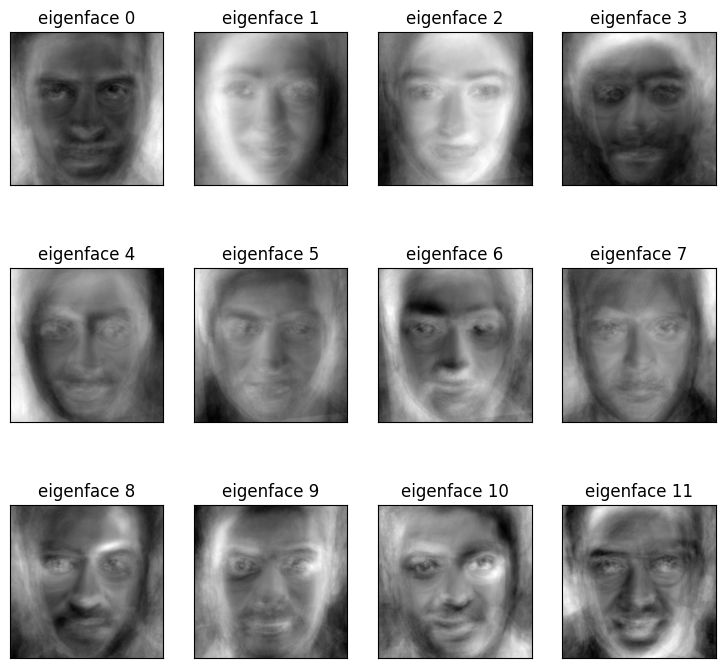

In [18]:
# Plot the gallery of the most significant eigenfaces
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)
plt.show()

In [19]:
print("Projecting the input data on the eigenfaces orthonormal basis")
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print(X_train_pca.shape, X_test_pca.shape)


Projecting the input data on the eigenfaces orthonormal basis
(337, 150) (113, 150)


In [20]:
# Compute Fisherfaces
lda = LinearDiscriminantAnalysis()

# Compute LDA of reduced data
lda.fit(X_train_pca, y_train)

X_train_lda = lda.transform(X_train_pca)
X_test_lda = lda.transform(X_test_pca)
print("LDA transformation done...")

# Training with Multi-layer Perceptron
clf = MLPClassifier(random_state=1, hidden_layer_sizes=(10, 10), max_iter=1000, verbose=True)
clf.fit(X_train_lda, y_train)


LDA transformation done...
Iteration 1, loss = 3.15390307
Iteration 2, loss = 3.09228960
Iteration 3, loss = 3.03676007
Iteration 4, loss = 2.97950491
Iteration 5, loss = 2.92282091
Iteration 6, loss = 2.87011494
Iteration 7, loss = 2.81582484
Iteration 8, loss = 2.76404099
Iteration 9, loss = 2.71521095
Iteration 10, loss = 2.66667958
Iteration 11, loss = 2.61900206
Iteration 12, loss = 2.57471492
Iteration 13, loss = 2.53005583
Iteration 14, loss = 2.48847768
Iteration 15, loss = 2.44557105
Iteration 16, loss = 2.40524777
Iteration 17, loss = 2.36648249
Iteration 18, loss = 2.32637722
Iteration 19, loss = 2.29127176
Iteration 20, loss = 2.25307310
Iteration 21, loss = 2.21859955
Iteration 22, loss = 2.18299023
Iteration 23, loss = 2.14877315
Iteration 24, loss = 2.11577999
Iteration 25, loss = 2.08354385
Iteration 26, loss = 2.05269379
Iteration 27, loss = 2.02105747
Iteration 28, loss = 1.99011463
Iteration 29, loss = 1.96037504
Iteration 30, loss = 1.93002313
Iteration 31, loss = 1

MLPClassifier(hidden_layer_sizes=(10, 10), max_iter=1000, random_state=1,
              verbose=True)

In [21]:
print("Model Weights:")
model_info = [coef.shape for coef in clf.coefs_]
print(model_info)

Model Weights:
[(8, 10), (10, 10), (10, 9)]


In [22]:
# Prediction and evaluation
y_pred = []
y_prob = []

for test_face in X_test_lda:
    prob = clf.predict_proba([test_face])[0]
    class_id = np.where(prob == np.max(prob))[0][0]
    y_pred.append(class_id)
    y_prob.append(np.max(prob))

In [23]:
# Transform the data
y_pred = np.array(y_pred)
prediction_titles = []
true_positive = 0


Accuracy: 71.68141592920354


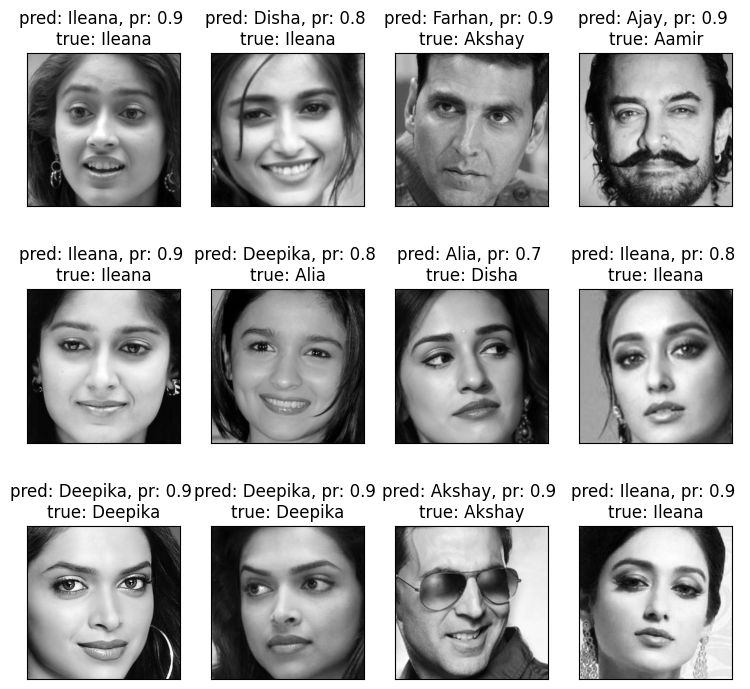

In [24]:
for i in range(y_pred.shape[0]):
    true_name = class_names[y_test[i]]
    pred_name = class_names[y_pred[i]]
    result = 'pred: %s, pr: %s \ntrue: %s' % (pred_name, str(y_prob[i])[:3], true_name)
    prediction_titles.append(result)
    if true_name == pred_name:
        true_positive += 1

print("Accuracy:", true_positive * 100 / y_pred.shape[0])

# Plot results
plot_gallery(X_test, prediction_titles, h, w)
plt.show()